In [1]:
from IPython.utils import io
import numpy as np
import collections

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

import scipy.io
from scipy import signal,integrate
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Dropout

import mne 
import math

import pickle

n_sec=60
n_seg=2*n_sec-1
n_points=n_sec*128
bottleneck=12

In [2]:
pyt=pickle.load(open('DEAP/s01.dat','rb'),encoding='latin1')
#taking only 32 channels(eeg ones) into account #disregarding the first three seconds of each trial
data=pyt['data'][:,0:32,3*128:]
labels=pyt['labels'][:,:3]
single_data=data[0]

#changing to mne format('biosemi32' used in the dataset)
biosemi32_format=mne.channels.make_standard_montage('biosemi32')
#create a basic info instance suitable to use with create_raw
info=mne.create_info(ch_names=biosemi32_format.ch_names, ch_types='eeg',sfreq=128)
#for evoked data of the first trial
raw=mne.EvokedArray(single_data,info)

print(data.shape)
print(labels.shape)
print(np.amax(data))
print(np.amin(data))

(40, 32, 7680)
(40, 3)
126.13356159993128
-93.12451745086868


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


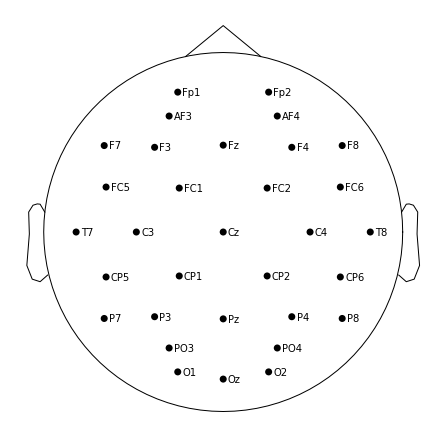

In [3]:
biosemi32_format.plot(kind='topomap',show_names=True);

Creating RawArray with float64 data, n_channels=16, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Using matplotlib as 2D backend.
Opening raw-browser...


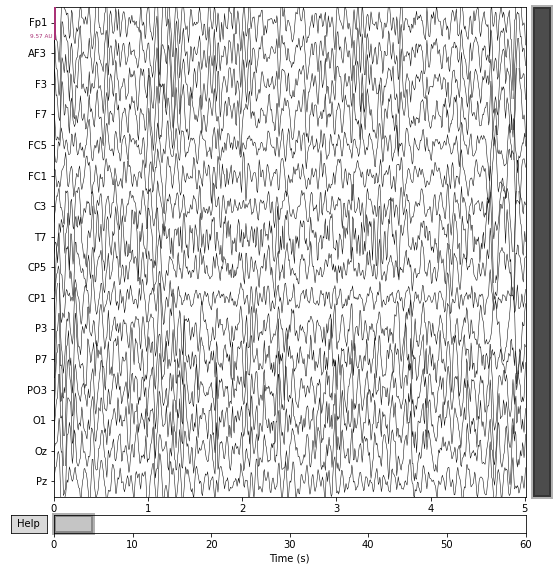

In [4]:
single_data1=data[0,:16]
info1=mne.create_info(ch_names=['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz'],sfreq=128)
raw1=mne.io.RawArray(single_data1,info1,first_samp=0,copy='auto',verbose=None)
raw1.plot(duration=5,n_channels=16);

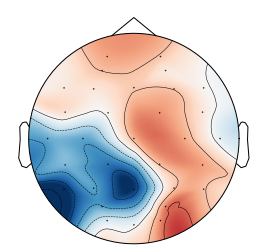

In [5]:
raw=raw.set_montage(biosemi32_format)
mne.viz.plot_topomap(raw.data[:,0],raw.info,show=False);

Creating RawArray with float64 data, n_channels=1, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Opening raw-browser...


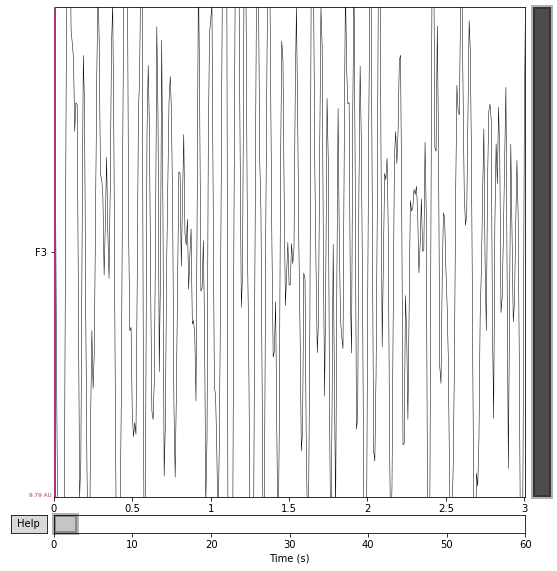

In [6]:
single_data1=data[0,:1]
info1=mne.create_info(ch_names=['F3'],sfreq=128)
raw1=mne.io.RawArray(single_data1,info1,first_samp=0,copy='auto',verbose=None)
raw1.plot(duration=3,n_channels=1);

In [7]:
def convertOneSubjectData(fileName):
    pth=pickle.load(open(fileName,'rb'),encoding='latin1')
    labels=pth['labels'][:,0:3]#valence arousal and dominance
    data=pth['data'][:,0:32,3*128:]# only first 32 channels ['Fp1','AF3','F3','F7','FC5',
    #'FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4',
    #'F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
    valence_labels,valence_data=[],[]
    arousal_labels,arousal_data=[],[]
    dominance_labels,dominance_data=[],[]
    
    for i, label in enumerate(labels):
        valence,arousal,dominance=label[0],label[1],label[2]
        if(valence>5):
            valence_labels.append(1)
            valence_data.append(data[i])
        if(valence<4):
            valence_labels.append(0)
            valence_data.append(data[i])
        if arousal > 5:
            arousal_labels.append(1)
            arousal_data.append(data[i])
        if arousal < 4:
            arousal_labels.append(0)
            arousal_data.append(data[i])
        if dominance <4:
            dominance_labels.append(0)
            dominance_data.append(data[i])
        if(dominance >5):
            dominance_labels.append(0)
            dominance_data.append(data[i])
            
    print("valence:",len(valence_labels),"arousal: ",len(arousal_labels),"dominance : ",len(dominance_labels));
    return valence_labels,valence_data,arousal_labels,arousal_data,dominance_labels,dominance_data;

In [8]:
def standardize(a,multiple):
    std=np.std(a)
    mean=np.mean(a)
    a=(a-mean)/std
    return multiple*a

In [9]:
def convertAllData():
    valence_labels_all,valence_data_all=[],[]
    arousal_labels_all,arousal_data_all=[],[]
    dominance_labels_all,dominance_data_all=[],[]
    
    for i in range(32):
        if(i<9):
            file="0"+str(i+1)
        else:
            file=str(i+1)
        file_name='DEAP/s'+file+'.dat'
        print(file_name)
        valence_labels,valence_data,arousal_labels,arousal_data,dominance_labels,dominance_data=convertOneSubjectData(file_name)
        valence_labels_all+=valence_labels
        for d in valence_data:
            d=standardize(d,1)
            valence_data_all.append(d)
        arousal_labels_all+=arousal_labels
        for d in arousal_data:
            d=standardize(d,1)
            arousal_data_all.append(d)
        dominance_labels_all+=dominance_labels
        for d in dominance_data:
            d=standardize(d,1)
            dominance_data_all.append(d)
        
    valence_labels_all=np.array(valence_labels_all)
    valence_data_all=np.array(valence_data_all)
    arousal_labels_all=np.array(arousal_labels_all)
    arousal_data_all=np.array(arousal_data_all)
    dominance_labels_all=np.array(dominance_labels_all)
    dominance_data_all=np.array(dominance_data_all)
    
    print("Valence trial data for all subject: ", valence_labels_all.shape,valence_data_all.shape)
    print("Arousal trial data for all subject: ", arousal_labels_all.shape,arousal_data_all.shape)
    print("Dominance trial data fro all subject:",dominance_labels_all.shape,dominance_data_all.shape)
    
    # save numpy array of total data to files
    np.save('DEAP/valence/' + 'all_valence_labels.npy',valence_labels_all)
    np.save('DEAP/valence/' + 'all_valence_data.npy', valence_data_all)
    np.save('DEAP/arousal/' + 'all_arousal_labels.npy',arousal_labels_all)
    np.save('DEAP/arousal/' + 'all_arousal_data.npy', arousal_data_all)
    np.save('DEAP/dominance/' + 'all_dominance_labels.npy',dominance_labels_all)
    np.save('DEAP/dominance/' + 'all_dominance_data.npy', dominance_data_all)

In [10]:
convertAllData()

DEAP/s01.dat
valence: 37 arousal:  39 dominance :  38
DEAP/s02.dat
valence: 31 arousal:  37 dominance :  38
DEAP/s03.dat
valence: 27 arousal:  32 dominance :  27
DEAP/s04.dat
valence: 36 arousal:  37 dominance :  33
DEAP/s05.dat
valence: 33 arousal:  28 dominance :  34
DEAP/s06.dat
valence: 35 arousal:  32 dominance :  37
DEAP/s07.dat
valence: 37 arousal:  35 dominance :  38
DEAP/s08.dat
valence: 30 arousal:  30 dominance :  36
DEAP/s09.dat
valence: 32 arousal:  25 dominance :  29
DEAP/s10.dat
valence: 33 arousal:  34 dominance :  33
DEAP/s11.dat
valence: 35 arousal:  36 dominance :  36
DEAP/s12.dat
valence: 36 arousal:  38 dominance :  39
DEAP/s13.dat
valence: 30 arousal:  37 dominance :  36
DEAP/s14.dat
valence: 39 arousal:  38 dominance :  37
DEAP/s15.dat
valence: 32 arousal:  29 dominance :  33
DEAP/s16.dat
valence: 35 arousal:  38 dominance :  34
DEAP/s17.dat
valence: 31 arousal:  34 dominance :  35
DEAP/s18.dat
valence: 28 arousal:  30 dominance :  36
DEAP/s19.dat
valence: 35 aro

In [11]:
def load_data(dim):
    if dim=='valence':
        labels_all=np.load('DEAP/valence/' + 'all_valence_labels.npy',allow_pickle=True)
        data_all=np.load('DEAP/valence/' + 'all_valence_data.npy',allow_pickle=True)
        print("Valence :",labels_all.shape,data_all.shape)
    elif dim=='arousal':
        labels_all=np.load('DEAP/arousal/'+'all_arousal_labels.npy',allow_pickle=True)
        data_all=np.load('DEAP/arousal/'+'all_arousal_data.npy',allow_pickle=True)
        print("Arousal: ",labels_all.shape,data_all.shape)
    elif dim=='dominance':
        labels_all=np.load('DEAP/dominance/all_dominance_labels.npy',allow_pickle=True)
        data_all=np.load('DEAP/dominance/all_dominance_data.npy',allow_pickle=True)
        print("Dominance: ",labels_all.shape,data_all.shape) 
    return labels_all,data_all

In [12]:
labels_all_val,data_all_val=load_data(dim='valence')

Valence : (1064,) (1064, 32, 7680)


In [13]:
labels_all_ar,data_all_ar=load_data(dim='arousal')

Arousal:  (1105,) (1105, 32, 7680)


In [14]:
labels_all_dom,data_all_dom=load_data(dim='dominance')

Dominance:  (1122,) (1122, 32, 7680)


In [15]:
print(np.amax(data_all_ar))
print(np.amin(data_all_ar))

91.75265724740024
-100.00674912321686


In [16]:
#Feature extraction using PSD
def PSD_extraction(data):
    info = mne.create_info(ch_names=['1','2','3','4','5','6','7','8','9','10','11','12'],sfreq=128);
    raw=mne.io.RawArray(data,info,first_samp=0,copy='auto',verbose=None);
    psd_origin, f=mne.time_frequency.psd_welch(raw,fmin=0,fmax=60,n_fft=128,n_overlap=64,n_per_seg=128,picks='all',window='hann',average=None)
    psd=np.moveaxis(psd_origin,-1,0)
    band_power=[]
    for segment in psd:
        segment_band_p=[]#band power for all channels in one segment
        for psd_channel in segment:
            y_int=integrate.cumtrapz(psd_channel,f,initial=0)#integrate this to calculate bandpower
            one_band_p=np.array([y_int[7]-y_int[4],y_int[13]-y_int[8],y_int[30]-y_int[14],y_int[51]-y_int[31]])
            segment_band_p.append(one_band_p)
        band_power.append(segment_band_p)
    band_power=np.array(band_power)
    band_power=np.moveaxis(band_power,-1,1)
    band_power=band_power.reshape((n_seg,bottleneck*4))
    band_power=10*band_power
    return band_power
    

In [17]:
#code for transforming eeg data shape
# change dimension from (849, 32, 7680)to (849, 8064, 32) then to (6846336, 32) for input 32-dimension vector to autoencoder
def vector_transform(data):
    vectors = np.moveaxis(data, 1, -1)
    vectors = vectors.reshape((vectors.shape[0]*vectors.shape[1], vectors.shape[2]))
    return vectors

# change output of autoencoder dimension from (6846336, 12) to (849, 8064, 12) then to (849, 12, 8064)
def inverse_vector_transform(vectors):
    data = vectors.reshape((int(vectors.shape[0]/n_points), n_points, vectors.shape[1]))
    data = np.moveaxis(data, -1, 1)
    return data

In [18]:
#10 fold cross verification(dividing the data so that it beconmes a multiple of 10)
data_all,labels_all=shuffle(data_all_ar,labels_all_ar,random_state=42)
n=len(labels_all)
print(n)
fold_n=math.floor(n/10)
print(fold_n)
data_all,labels_all=data_all[:10*fold_n],labels_all[:10*fold_n]
print(data_all.shape)
print(labels_all.shape)

1105
110
(1100, 32, 7680)
(1100,)


In [19]:
def process(test_fold_number):
    train_data=np.concatenate((data_all[:test_fold_number*fold_n],data_all[fold_n+test_fold_number*fold_n:]),axis=0)
    train_labels=np.concatenate((labels_all[:test_fold_number*fold_n],labels_all[fold_n+test_fold_number*fold_n:]),axis=0)
    test_data=data_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    test_labels=labels_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape)
    
    #changing dimension to 32 dimension vector for input to autoencoder
    train_vectors=vector_transform(train_data)
    test_vectors=vector_transform(test_data)
    print(train_vectors.shape,test_vectors.shape)
    
    #create new autoencoder
    input_=Input(shape=(32,))
    encoded=Dense(64,activation=None)(input_)
    bottleneck_layer=Dense(bottleneck,activation=None)(encoded)
    decoded=Dense(64,activation=None)(bottleneck_layer)
    decoded=Dense(32,activation=None)(decoded)
    autoencoder=Model(input_,decoded)
    
    encoder=Model(input_,bottleneck_layer)
    
    decoder_input_layer=Input(shape=(bottleneck,))
    decoder_layer=autoencoder.layers[-2](decoder_input_layer)
    decoder_layer=autoencoder.layers[-1](decoder_layer)
    decoder=Model(decoder_input_layer,decoder_layer)
    
    #compile and train autoencoder
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
    autoencoder.save("../Results/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))
    
    # -------- Encode train and test data by pass through encoder --------
    train_data_encoded = encoder.predict(train_vectors)
    train_data_encoded = inverse_vector_transform(train_data_encoded) 
    test_data_encoded = encoder.predict(test_vectors) 
    test_data_encoded = inverse_vector_transform(test_data_encoded) 
    print("Encoded training data shape: ", train_data_encoded.shape)
    print("Encoded test data shape: ", test_data_encoded.shape)
    
    # -------- Feature extraction from 12 source signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data_encoded: # for every train trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) # data shape (12, 8064)
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)
    
    test_band_power = [] # band power feature sequence for test trials
    for data in test_data_encoded: # for every test trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) # data shape (12, 8064)
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
    print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)
    
    # -------- Create new LSTM model --------
    x=Input(shape=(n_seg,bottleneck*4)) # flatten (12,4) to 48
    x1=LSTM(n_seg)(x)
    x2=Dense(n_seg)(x1)
    x3=Dense(12)(x2)
    output=Dense(1, activation="sigmoid")(x2)
    model=Model(x, output)
    print(train_band_power.shape,train_labels.shape,test_band_power.shape,test_labels.shape)

    # -------- Compile and train LSTM --------
    model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    history = model.fit(train_band_power, train_labels, epochs=30, validation_data=(test_band_power, test_labels))
    print("Hightest accuracy: " + str(max(history.history['val_accuracy'])))
    model.save("../Results/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))    

In [20]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 141s 1ms/step - loss: 0.2259 - accuracy: 0.4451 - val_loss: 0.2203 - val_accuracy: 0.4699
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets
Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 5s 86ms/step - loss: 0.2307 - accuracy: 0.6475 - val_loss: 0.2563 - val_accuracy: 0.5909
Epoch 2/30
31/31 [==============================] - 2s 75ms/step - loss: 0.2195 - accuracy: 0.6707 - val_loss: 0.2515 - val_accuracy: 0.5909
Epoch 3/30
31/31 [==============================] - 2s 74ms/step - loss: 0.2135 - accuracy: 0.6747 - val_loss: 0.2466 - val_accuracy: 0.5909
Epoch 4/

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


********** Test Fold 1 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 156s 1ms/step - loss: 0.2254 - accuracy: 0.4492 - val_loss: 0.2293 - val_accuracy: 0.4348
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 6s 117ms/step - loss: 0.2401 - accuracy: 0.5970 - val_loss: 0.2395 - val_accuracy: 0.6545
Epoch 2/30
31/31 [==============================] - 3s 82ms/step - loss: 0.2203 - accuracy: 0.6687 - val_loss: 0.2336 - val_accuracy: 0.6273
Epoch 3/30
31/31 [==============================] - 3s 113ms/step - loss: 0.2137 - accuracy: 0.6758 - val_loss: 0.2315 - val_accuracy: 0.6364
Epoch 4/30
31/31 [==============================] - 3s 104ms/step - loss: 0.2092 - accuracy: 0.6808 - val_loss: 0.2299 - val_accuracy: 0.6545
Epoch 5/30
31/31 [==============================] - 3s 105ms/step - loss: 0.2058 - accuracy: 0.6919 - val_loss: 0.2292 - val_accuracy: 0.6727
Epoch 6/30
31/31 [==============================] - 3s 98

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


********** Test Fold 2 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 232s 2ms/step - loss: 0.2261 - accuracy: 0.4484 - val_loss: 0.2196 - val_accuracy: 0.4571
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 6s 110ms/step - loss: 0.2377 - accuracy: 0.5859 - val_loss: 0.2374 - val_accuracy: 0.6000
Epoch 2/30
31/31 [==============================] - 3s 91ms/step - loss: 0.2193 - accuracy: 0.6525 - val_loss: 0.2330 - val_accuracy: 0.6091
Epoch 3/30
31/31 [==============================] - 3s 94ms/step - loss: 0.2128 - accuracy: 0.6707 - val_loss: 0.2321 - val_accuracy: 0.6182
Epoch 4/30
31/31 [==============================] - 3s 91ms/step - loss: 0.2081 - accuracy: 0.6808 - val_loss: 0.2300 - val_accuracy: 0.6182
Epoch 5/30
31/31 [==============================] - 3s 91ms/step - loss: 0.2038 - accuracy: 0.6889 - val_loss: 0.2283 - val_accuracy: 0.6182
Epoch 6/30
31/31 [==============================] - 3s 91ms/

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


********** Test Fold 3 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 203s 2ms/step - loss: 0.2251 - accuracy: 0.4513 - val_loss: 0.2315 - val_accuracy: 0.4496
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 123ms/step - loss: 0.2516 - accuracy: 0.5545 - val_loss: 0.2363 - val_accuracy: 0.6182
Epoch 2/30
31/31 [==============================] - 3s 98ms/step - loss: 0.2265 - accuracy: 0.6545 - val_loss: 0.2292 - val_accuracy: 0.6364
Epoch 3/30
31/31 [==============================] - 3s 98ms/step - loss: 0.2171 - accuracy: 0.6869 - val_loss: 0.2254 - val_accuracy: 0.6636
Epoch 4/30
31/31 [==============================] - 3s 98ms/step - loss: 0.2113 - accuracy: 0.6949 - val_loss: 0.2210 - val_accuracy: 0.6636
Epoch 5/30
31/31 [==============================] - 3s 100ms/step - loss: 0.2067 - accuracy: 0.6970 - val_loss: 0.2176 - val_accuracy: 0.6636
Epoch 6/30
31/31 [==============================] - 3s 103m

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


********** Test Fold 4 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 197s 2ms/step - loss: 0.2261 - accuracy: 0.4495 - val_loss: 0.2286 - val_accuracy: 0.4409
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 130ms/step - loss: 0.2397 - accuracy: 0.5909 - val_loss: 0.2279 - val_accuracy: 0.6545
Epoch 2/30
31/31 [==============================] - 3s 107ms/step - loss: 0.2184 - accuracy: 0.6646 - val_loss: 0.2204 - val_accuracy: 0.6727
Epoch 3/30
31/31 [==============================] - 3s 105ms/step - loss: 0.2114 - accuracy: 0.6727 - val_loss: 0.2173 - val_accuracy: 0.6909
Epoch 4/30
31/31 [==============================] - 3s 106ms/step - loss: 0.2067 - accuracy: 0.6697 - val_loss: 0.2168 - val_accuracy: 0.6909
Epoch 5/30
31/31 [==============================] - 3s 106ms/step - loss: 0.2032 - accuracy: 0.6859 - val_loss: 0.2157 - val_accuracy: 0.6909
Epoch 6/30
31/31 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


********** Test Fold 5 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 220s 2ms/step - loss: 0.2263 - accuracy: 0.4490 - val_loss: 0.2159 - val_accuracy: 0.4428
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 151ms/step - loss: 0.2467 - accuracy: 0.5545 - val_loss: 0.2292 - val_accuracy: 0.6364
Epoch 2/30
31/31 [==============================] - 4s 129ms/step - loss: 0.2247 - accuracy: 0.6434 - val_loss: 0.2181 - val_accuracy: 0.6636
Epoch 3/30
31/31 [==============================] - 4s 130ms/step - loss: 0.2177 - accuracy: 0.6596 - val_loss: 0.2133 - val_accuracy: 0.6636
Epoch 4/30
31/31 [==============================] - 4s 131ms/step - loss: 0.2131 - accuracy: 0.6687 - val_loss: 0.2088 - val_accuracy: 0.6909
Epoch 5/30
31/31 [==============================] - 4s 129ms/step - loss: 0.2093 - accuracy: 0.6717 - val_loss: 0.2049 - val_accuracy: 0.6909
Epoch 6/30
31/31 [==============================] - 4s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


********** Test Fold 6 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 206s 2ms/step - loss: 0.2253 - accuracy: 0.4481 - val_loss: 0.2305 - val_accuracy: 0.4477
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 159ms/step - loss: 0.2493 - accuracy: 0.5596 - val_loss: 0.2369 - val_accuracy: 0.6000
Epoch 2/30
31/31 [==============================] - 4s 138ms/step - loss: 0.2244 - accuracy: 0.6455 - val_loss: 0.2295 - val_accuracy: 0.6182
Epoch 3/30
31/31 [==============================] - 4s 138ms/step - loss: 0.2164 - accuracy: 0.6636 - val_loss: 0.2244 - val_accuracy: 0.6364
Epoch 4/30
31/31 [==============================] - 4s 138ms/step - loss: 0.2114 - accuracy: 0.6677 - val_loss: 0.2217 - val_accuracy: 0.6364
Epoch 5/30
31/31 [==============================] - 4s 138ms/step - loss: 0.2076 - accuracy: 0.6747 - val_loss: 0.2192 - val_accuracy: 0.6455
Epoch 6/30
31/31 [==============================] - 4s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


********** Test Fold 7 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 190s 2ms/step - loss: 0.2239 - accuracy: 0.4524 - val_loss: 0.2414 - val_accuracy: 0.4342
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 8s 174ms/step - loss: 0.2311 - accuracy: 0.6283 - val_loss: 0.2041 - val_accuracy: 0.7091
Epoch 2/30
31/31 [==============================] - 5s 153ms/step - loss: 0.2210 - accuracy: 0.6545 - val_loss: 0.1961 - val_accuracy: 0.7455
Epoch 3/30
31/31 [==============================] - 5s 150ms/step - loss: 0.2160 - accuracy: 0.6616 - val_loss: 0.1939 - val_accuracy: 0.7455
Epoch 4/30
31/31 [==============================] - 5s 151ms/step - loss: 0.2119 - accuracy: 0.6737 - val_loss: 0.1924 - val_accuracy: 0.7455
Epoch 5/30
31/31 [==============================] - 5s 158ms/step - loss: 0.2088 - accuracy: 0.6747 - val_loss: 0.1914 - val_accuracy: 0.7636
Epoch 6/30
31/31 [==============================] - 5s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


********** Test Fold 8 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 201s 1ms/step - loss: 0.2273 - accuracy: 0.4505 - val_loss: 0.2208 - val_accuracy: 0.4399
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 9s 196ms/step - loss: 0.2422 - accuracy: 0.5798 - val_loss: 0.2118 - val_accuracy: 0.7273
Epoch 2/30
31/31 [==============================] - 6s 179ms/step - loss: 0.2172 - accuracy: 0.6626 - val_loss: 0.2017 - val_accuracy: 0.7364
Epoch 3/30
31/31 [==============================] - 5s 175ms/step - loss: 0.2104 - accuracy: 0.6677 - val_loss: 0.1993 - val_accuracy: 0.7273
Epoch 4/30
31/31 [==============================] - 5s 173ms/step - loss: 0.2053 - accuracy: 0.6717 - val_loss: 0.1982 - val_accuracy: 0.7455
Epoch 5/30
31/31 [==============================] - 5s 173ms/step - loss: 0.2011 - accuracy: 0.6859 - val_loss: 0.1949 - val_accuracy: 0.7273
Epoch 6/30
31/31 [==============================] - 5s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


********** Test Fold 9 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 225s 2ms/step - loss: 0.2261 - accuracy: 0.4492 - val_loss: 0.2224 - val_accuracy: 0.4524
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 10s 239ms/step - loss: 0.2329 - accuracy: 0.6192 - val_loss: 0.2355 - val_accuracy: 0.6182
Epoch 2/30
31/31 [==============================] - 7s 210ms/step - loss: 0.2209 - accuracy: 0.6586 - val_loss: 0.2318 - val_accuracy: 0.6273
Epoch 3/30
31/31 [==============================] - 6s 206ms/step - loss: 0.2153 - accuracy: 0.6667 - val_loss: 0.2288 - val_accuracy: 0.6364
Epoch 4/30
31/31 [==============================] - 7s 210ms/step - loss: 0.2112 - accuracy: 0.6697 - val_loss: 0.2263 - val_accuracy: 0.6455
Epoch 5/30
31/31 [==============================] - 7s 212ms/step - loss: 0.2080 - accuracy: 0.6727 - val_loss: 0.2241 - val_accuracy: 0.6364
Epoch 6/30
31/31 [==============================] - 7s 

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


Effective window size : 1.000 (s)
(32, 61, 119) (61,)


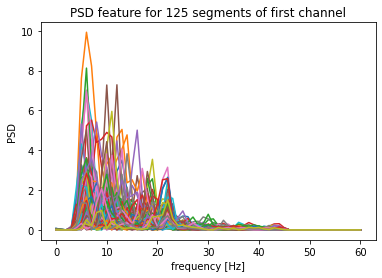

In [21]:
#calculate PSD of all channels using welch method
psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
print(psd_origin.shape, f.shape) # (12, 61, 125) (61,)
plt.plot(f, psd_origin[0]) # first channel psd of 125 segments
plt.title("PSD feature for 125 segments of first channel")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [23]:
#comparing original and standardized data
standardised_data = standardize(single_data, 1)

print(np.amax(single_data)) # max value
print(np.amin(single_data)) # min value
print(np.amax(standardised_data)) # max value
print(np.amin(standardised_data)) # min value

33.46697829071114
-31.335874596603272
8.319613243657404
-7.789838539676195


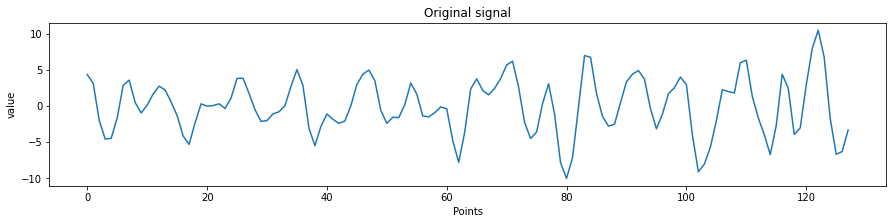

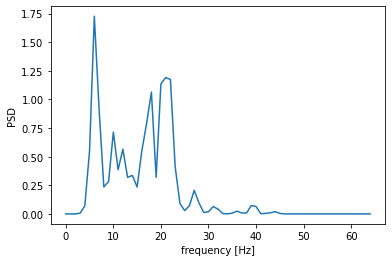

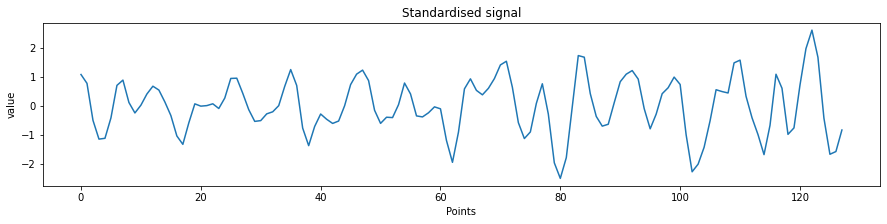

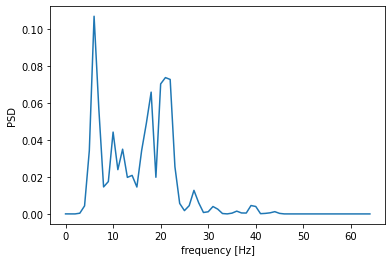

In [25]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(single_data[0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(single_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(standardised_data[0][nth*128:nth*128+128])
plt.title("Standardised signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(standardised_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

8.319613243657404
-7.789838539676195
(15360, 32)


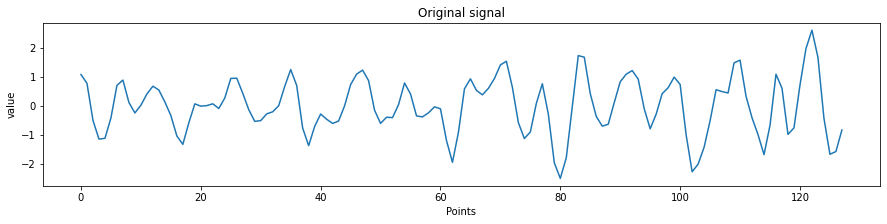

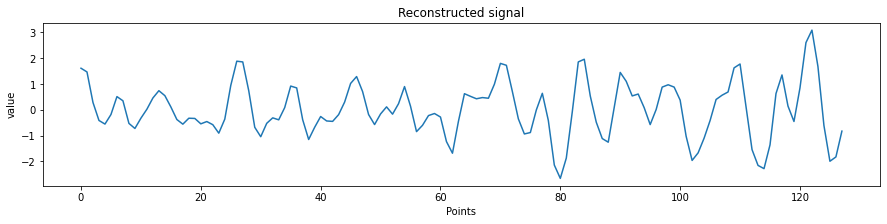

In [27]:
#Compare original signal and reconstructed signal
autoencoder = keras.models.load_model("../Results/autoencoder_model/autoencoder_model_test_fold_1")
temp = data[:2] # first two trial
data_ = []
for t in temp:
    data_.append(standardize(t, 1))
print(np.amax(data_[0])) # max value
print(np.amin(data_[0])) # min value
8.3196132436574
-7.789838539676193
data_ = np.array(data_)
data_vector = vector_transform(data_)
print(data_vector.shape)
data_reconstructed_vector = autoencoder.predict(data_vector)
data_reconstructed = inverse_vector_transform(data_reconstructed_vector) 
data_reconstructed.shape
(15360, 32)
(2, 32, 7680)
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(data_[0][0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(data_reconstructed[0][0][nth*128:nth*128+128])
plt.title("Reconstructed signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()